Name: Yesha Patel

Student ID: 000790164

# Sentiment Analysis on Company Reviews

# Data Loading

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
# Load the datasets
movie_reviews = pd.read_csv('/content/drive/My Drive/Sentiment_Analysis/train.csv', encoding='ISO-8859-1')

# Inspecting Dataset

In [4]:
movie_reviews.isnull().values.any().sum()

0

In [5]:
movie_reviews.shape

(60000, 3)

In [6]:
movie_reviews.head()

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [7]:
movie_reviews["Review"][3]

'Fantastic! Extremely easy to use website, fantastic range of batteries, fantastic packaging , dispatch and delivery service and all of that at fantastic prices! A first class company to deal with ð\x9f\x91\x8d'

<Axes: xlabel='Rating', ylabel='count'>

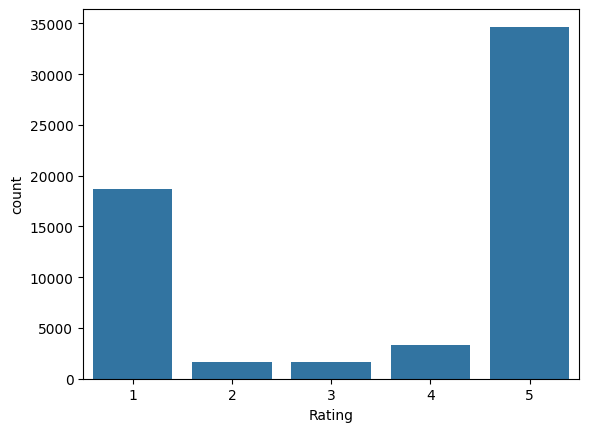

In [8]:
import seaborn as sns

sns.countplot(x='Rating', data=movie_reviews)

# Data Preprocessing

In [9]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
X = []
sentences = list(movie_reviews['Review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
X[3]


'Fantastic Extremely easy to use website fantastic range of batteries fantastic packaging dispatch and delivery service and all of that at fantastic prices first class company to deal with '

In [13]:
# Map ratings to numeric categories
y = movie_reviews['Rating']
y = np.array(list(map(lambda x: 0 if x == 1 else (1 if x == 2 else (2 if x == 3 else (3 if x == 4 else 4))), y)))
# 0: Very Negative (Rating 1)
# 1: Negative (Rating 2)
# 2: Neutral (Rating 3)
# 3: Positive (Rating 4)
# 4: Very Positive (Rating 5)

# Data Splitting

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [15]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/Sentiment_Analysis/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [18]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Model Building and Training

## Simple Neural Network

In [19]:
from tensorflow.keras.utils import to_categorical

# Convert y to categorical for softmax
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# Model definition
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='softmax'))  # 5 output categories
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

# Evaluation
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7711 - loss: 0.7450 - val_accuracy: 0.8587 - val_loss: 0.4697
Epoch 2/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8611 - loss: 0.4411 - val_accuracy: 0.8600 - val_loss: 0.4556
Epoch 3/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8753 - loss: 0.3863 - val_accuracy: 0.8664 - val_loss: 0.4290
Epoch 4/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8900 - loss: 0.3337 - val_accuracy: 0.8654 - val_loss: 0.4252
Epoch 5/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9026 - loss: 0.2952 - val_accuracy: 0.8586 - val_loss: 0.4407
Epoch 6/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9118 - loss: 0.2669 - val_accuracy: 0.8612 - val_loss: 0.4403
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8621 - loss: 0.4466
Test Score: 0.4461134970188141
Test Accuracy: 0.8640833497047424


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


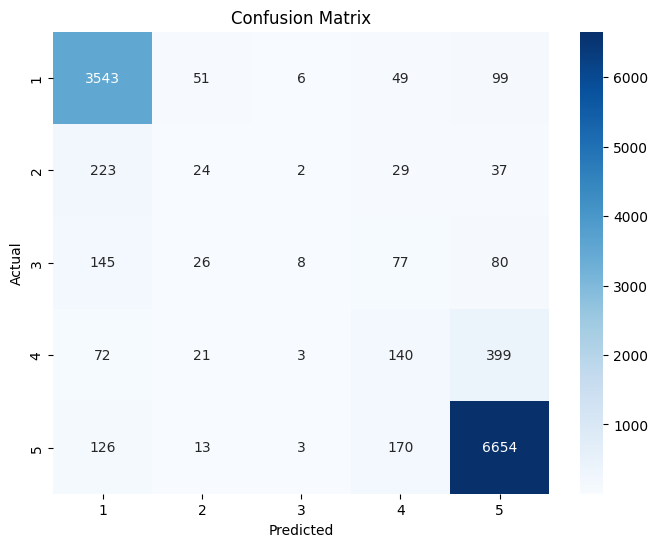

Classification Report:
              precision    recall  f1-score   support

    Rating 1       0.86      0.95      0.90      3748
    Rating 2       0.18      0.08      0.11       315
    Rating 3       0.36      0.02      0.04       336
    Rating 4       0.30      0.22      0.25       635
    Rating 5       0.92      0.96      0.93      6966

    accuracy                           0.86     12000
   macro avg       0.52      0.44      0.45     12000
weighted avg       0.83      0.86      0.84     12000



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test, verbose=1)

# Convert predictions and true labels from one-hot encoding to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[f'Rating {i}' for i in range(1, 6)]))


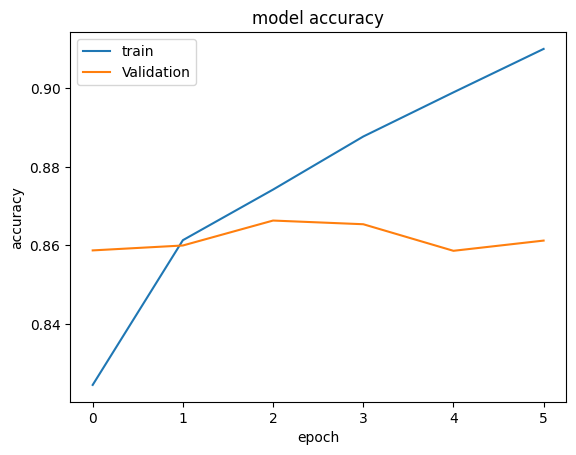

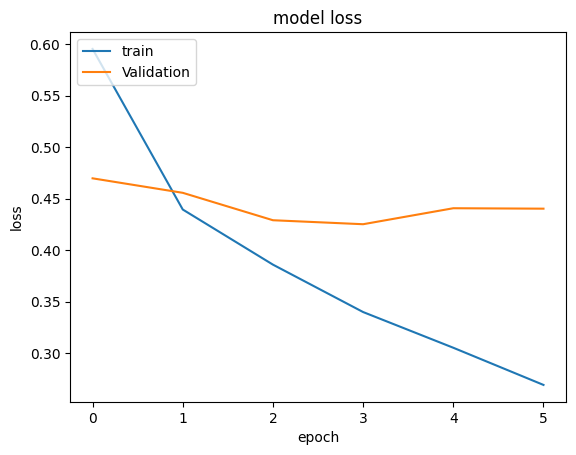

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

# Own Data Prediction

In [23]:
custom_reviews = [
    "I had a very disappointing experience with XYZ Company. The customer service was unresponsive and unhelpful when I had an issue with my order. I had to follow up multiple times before getting any resolution, and even then, it took weeks to receive a response. The product I received was not as described, and I felt like my concerns were brushed aside. Overall, I would not recommend this company to anyone, as their lack of communication and poor customer service made the entire experience frustrating.",
    "The product arrived damaged, and the replacement process was tedious and slow. Not worth the hassle.",
    "The product is okay for the price, but the quality could be improved. It’s functional but not exceptional.",
    "Decent experience, but there were a few hiccups with the setup. Works fine now but required effort to fix.",
    "I recently joined XYZ Company, and the experience has been fantastic! The work culture is incredibly supportive, and I feel like my contributions are truly valued. The management is open to feedback, and there are plenty of opportunities for growth and development. I also love the work-life balance they promote, which makes a huge difference. I would highly recommend XYZ to anyone looking for a dynamic and rewarding work environment."
]

def preprocess_custom_reviews(reviews):
    processed_reviews = []
    for review in reviews:
        # Removing HTML tags
        review = re.sub(r'<[^>]+>', '', review)
        # Removing punctuations and numbers
        review = re.sub('[^a-zA-Z]', ' ', review)
        # Removing single characters
        review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
        # Removing multiple spaces
        review = re.sub(r'\s+', ' ', review)
        processed_reviews.append(review)
    return processed_reviews

processed_custom_reviews = preprocess_custom_reviews(custom_reviews)

# Convert the processed custom reviews into sequences and pad them
custom_sequences = tokenizer.texts_to_sequences(processed_custom_reviews)
custom_padded = pad_sequences(custom_sequences, padding='post', maxlen=maxlen)

# Predict the sentiment of the custom reviews
predictions = model.predict(custom_padded)

# Interpret the output
sentiment_classes = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

for i, review in enumerate(custom_reviews):
    predicted_class = np.argmax(predictions[i])  # Get the class with the highest probability
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment_classes[predicted_class]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
Review: I had a very disappointing experience with XYZ Company. The customer service was unresponsive and unhelpful when I had an issue with my order. I had to follow up multiple times before getting any resolution, and even then, it took weeks to receive a response. The product I received was not as described, and I felt like my concerns were brushed aside. Overall, I would not recommend this company to anyone, as their lack of communication and poor customer service made the entire experience frustrating.
Predicted Sentiment: Very Negative

Review: The product arrived damaged, and the replacement process was tedious and slow. Not worth the hassle.
Predicted Sentiment: Very Positive

Review: The product is okay for the price, but the quality could be improved. It’s functional but not exceptional.
Predicted Sentiment: Neutral

Review: Decent experience, but there were a few hiccups with the setup. Works fine now but required effort to fix.
Predict

## LSTM (Long Short-Term Memory)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.7027 - loss: 0.9732 - val_accuracy: 0.8321 - val_loss: 0.5904
Epoch 2/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.8112 - loss: 0.6328 - val_accuracy: 0.8516 - val_loss: 0.5103
Epoch 3/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.8362 - loss: 0.5465 - val_accuracy: 0.8559 - val_loss: 0.4815
Epoch 4/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 121ms/step - accuracy: 0.8426 - loss: 0.5202 - val_accuracy: 0.8420 - val_loss: 0.5062
Epoch 5/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.8473 - loss: 0.5050 - val_accuracy: 0.8626 - val_loss: 0.4525
Epoch 6/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.8509 - loss: 0.4916 - val_accuracy: 0.8649 - val_loss: 0.4344
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.8642 - loss: 0.4393
LSTM Test Score: 0.43336451053619385
LSTM Test Accuracy: 0.8669999837875366


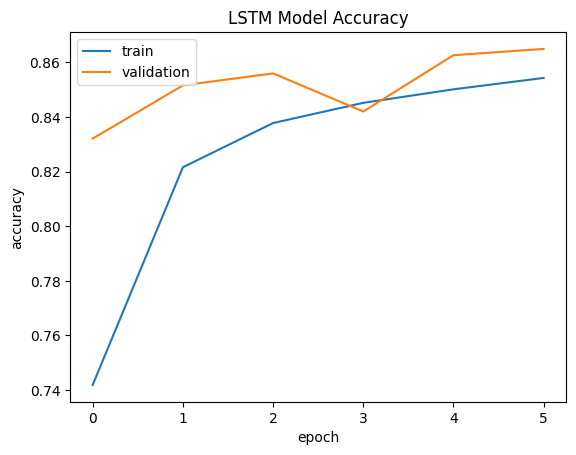

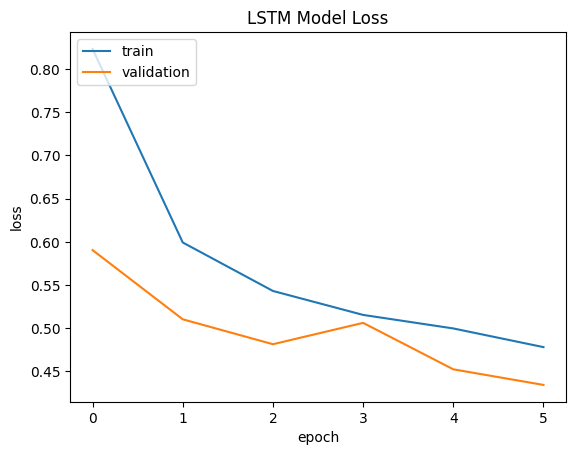

In [24]:
# LSTM Model
from keras.layers import LSTM

model_lstm = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model_lstm.add(embedding_layer)

# Add LSTM Layer
model_lstm.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

# Add Dense layer for sentiment classification
model_lstm.add(Dense(5, activation='softmax'))  # 5 output categories

# Compile the model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_lstm = model_lstm.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

# Evaluate the model
score_lstm = model_lstm.evaluate(X_test, y_test, verbose=1)
print("LSTM Test Score:", score_lstm[0])
print("LSTM Test Accuracy:", score_lstm[1])

# Plotting accuracy and loss
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step


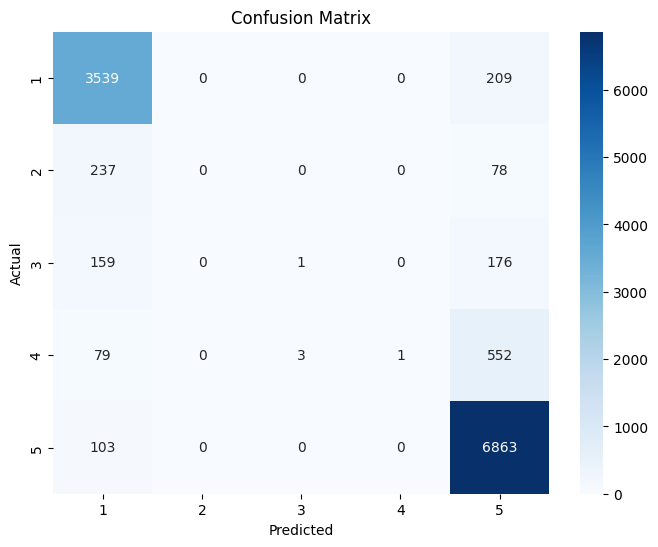

Classification Report:
              precision    recall  f1-score   support

    Rating 1       0.86      0.94      0.90      3748
    Rating 2       0.00      0.00      0.00       315
    Rating 3       0.25      0.00      0.01       336
    Rating 4       1.00      0.00      0.00       635
    Rating 5       0.87      0.99      0.92      6966

    accuracy                           0.87     12000
   macro avg       0.60      0.39      0.37     12000
weighted avg       0.83      0.87      0.82     12000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred = model_lstm.predict(X_test, verbose=1)

# Convert predictions and true labels from one-hot encoding to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[f'Rating {i}' for i in range(1, 6)]))


# Own Data Prediction

In [26]:
custom_reviews = [
    "I had a very disappointing experience with XYZ Company. The customer service was unresponsive and unhelpful when I had an issue with my order. I had to follow up multiple times before getting any resolution, and even then, it took weeks to receive a response. The product I received was not as described, and I felt like my concerns were brushed aside. Overall, I would not recommend this company to anyone, as their lack of communication and poor customer service made the entire experience frustrating.",
    "The product arrived damaged, and the replacement process was tedious and slow. Not worth the hassle.",
    "The product is okay for the price, but the quality could be improved. It’s functional but not exceptional.",
    "Decent experience, but there were a few hiccups with the setup. Works fine now but required effort to fix.",
    "I recently joined XYZ Company, and the experience has been fantastic! The work culture is incredibly supportive, and I feel like my contributions are truly valued. The management is open to feedback, and there are plenty of opportunities for growth and development. I also love the work-life balance they promote, which makes a huge difference. I would highly recommend XYZ to anyone looking for a dynamic and rewarding work environment."
]

def preprocess_custom_reviews(reviews):
    processed_reviews = []
    for review in reviews:
        # Removing HTML tags
        review = re.sub(r'<[^>]+>', '', review)
        # Removing punctuations and numbers
        review = re.sub('[^a-zA-Z]', ' ', review)
        # Removing single characters
        review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
        # Removing multiple spaces
        review = re.sub(r'\s+', ' ', review)
        processed_reviews.append(review)
    return processed_reviews

processed_custom_reviews = preprocess_custom_reviews(custom_reviews)

# Convert the processed custom reviews into sequences and pad them
custom_sequences = tokenizer.texts_to_sequences(processed_custom_reviews)
custom_padded = pad_sequences(custom_sequences, padding='post', maxlen=maxlen)

# Predict the sentiment of the custom reviews
predictions = model_lstm.predict(custom_padded)

# Interpret the output
sentiment_classes = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

for i, review in enumerate(custom_reviews):
    predicted_class = np.argmax(predictions[i])  # Get the class with the highest probability
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment_classes[predicted_class]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Review: I had a very disappointing experience with XYZ Company. The customer service was unresponsive and unhelpful when I had an issue with my order. I had to follow up multiple times before getting any resolution, and even then, it took weeks to receive a response. The product I received was not as described, and I felt like my concerns were brushed aside. Overall, I would not recommend this company to anyone, as their lack of communication and poor customer service made the entire experience frustrating.
Predicted Sentiment: Very Negative

Review: The product arrived damaged, and the replacement process was tedious and slow. Not worth the hassle.
Predicted Sentiment: Very Positive

Review: The product is okay for the price, but the quality could be improved. It’s functional but not exceptional.
Predicted Sentiment: Very Positive

Review: Decent experience, but there were a few hiccups with the setup. Works fine now but required effort to fix.
P

# GRU (Gated Recurrent Unit)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.6529 - loss: 2419.8071 - val_accuracy: 0.6787 - val_loss: 1.2650
Epoch 2/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.6713 - loss: 1.2133 - val_accuracy: 0.6792 - val_loss: 1.1206
Epoch 3/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.6725 - loss: 1.4898 - val_accuracy: 0.6770 - val_loss: 1.0441
Epoch 4/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.6691 - loss: 1.0355 - val_accuracy: 0.6775 - val_loss: 1.0002
Epoch 5/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.6669 - loss: 1.0008 - val_accuracy: 0.6785 - val_loss: 0.9751
Epoch 6/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.6697 - loss: 0.9824 - val_accuracy: 0.6791 - val_loss: 0.9600
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.6750 - loss: 0.9668
GRU Test Score: 0.9575777053833008
GRU Test Accuracy: 0.6788333058357239


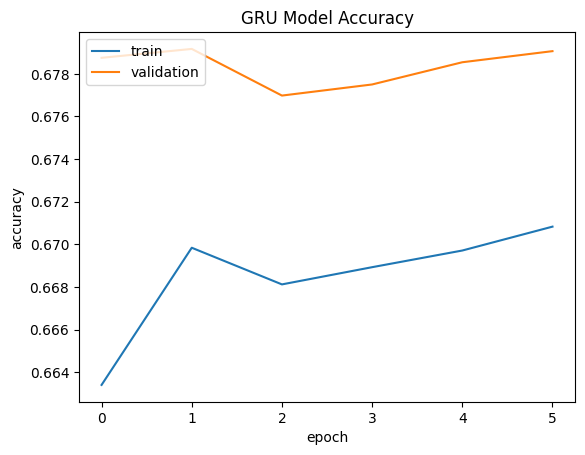

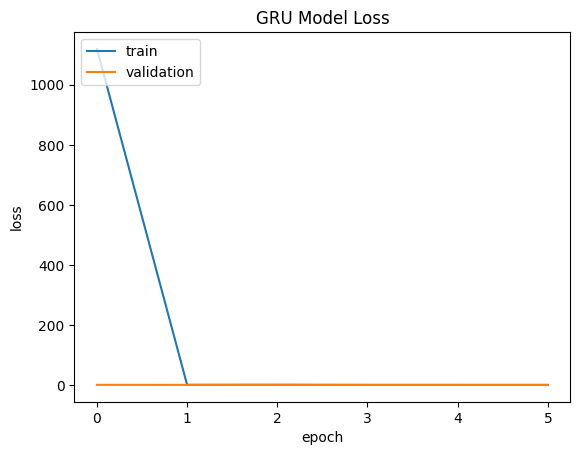

In [27]:
# GRU Model
from keras.layers import GRU

model_gru = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model_gru.add(embedding_layer)

# Add GRU Layer
model_gru.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2))

# Add Dense layer for sentiment classification
model_gru.add(Dense(5, activation='softmax'))  # 5 output categories

# Compile the model
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_gru = model_gru.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

# Evaluate the model
score_gru = model_gru.evaluate(X_test, y_test, verbose=1)
print("GRU Test Score:", score_gru[0])
print("GRU Test Accuracy:", score_gru[1])

# Plotting accuracy and loss
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('GRU Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('GRU Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step


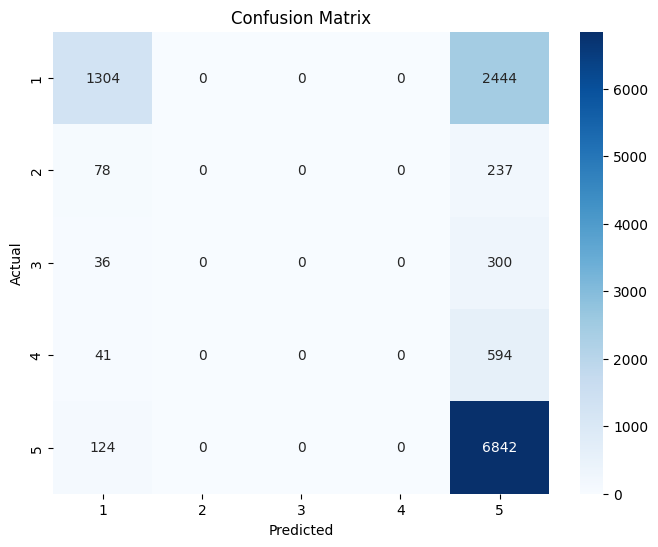

Classification Report:
              precision    recall  f1-score   support

    Rating 1       0.82      0.35      0.49      3748
    Rating 2       0.00      0.00      0.00       315
    Rating 3       0.00      0.00      0.00       336
    Rating 4       0.00      0.00      0.00       635
    Rating 5       0.66      0.98      0.79      6966

    accuracy                           0.68     12000
   macro avg       0.30      0.27      0.26     12000
weighted avg       0.64      0.68      0.61     12000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred = model_gru.predict(X_test, verbose=1)

# Convert predictions and true labels from one-hot encoding to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[f'Rating {i}' for i in range(1, 6)]))


## Own Data Prediction

In [29]:
custom_reviews = [
    "I had a very disappointing experience with XYZ Company. The customer service was unresponsive and unhelpful when I had an issue with my order. I had to follow up multiple times before getting any resolution, and even then, it took weeks to receive a response. The product I received was not as described, and I felt like my concerns were brushed aside. Overall, I would not recommend this company to anyone, as their lack of communication and poor customer service made the entire experience frustrating.",
    "The product arrived damaged, and the replacement process was tedious and slow. Not worth the hassle.",
    "The product is okay for the price, but the quality could be improved. It’s functional but not exceptional.",
    "Decent experience, but there were a few hiccups with the setup. Works fine now but required effort to fix.",
    "I recently joined XYZ Company, and the experience has been fantastic! The work culture is incredibly supportive, and I feel like my contributions are truly valued. The management is open to feedback, and there are plenty of opportunities for growth and development. I also love the work-life balance they promote, which makes a huge difference. I would highly recommend XYZ to anyone looking for a dynamic and rewarding work environment."
]

def preprocess_custom_reviews(reviews):
    processed_reviews = []
    for review in reviews:
        # Removing HTML tags
        review = re.sub(r'<[^>]+>', '', review)
        # Removing punctuations and numbers
        review = re.sub('[^a-zA-Z]', ' ', review)
        # Removing single characters
        review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
        # Removing multiple spaces
        review = re.sub(r'\s+', ' ', review)
        processed_reviews.append(review)
    return processed_reviews

processed_custom_reviews = preprocess_custom_reviews(custom_reviews)

# Convert the processed custom reviews into sequences and pad them
custom_sequences = tokenizer.texts_to_sequences(processed_custom_reviews)
custom_padded = pad_sequences(custom_sequences, padding='post', maxlen=maxlen)

# Predict the sentiment of the custom reviews
predictions = model_gru.predict(custom_padded)

# Interpret the output
sentiment_classes = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

for i, review in enumerate(custom_reviews):
    predicted_class = np.argmax(predictions[i])  # Get the class with the highest probability
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment_classes[predicted_class]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Review: I had a very disappointing experience with XYZ Company. The customer service was unresponsive and unhelpful when I had an issue with my order. I had to follow up multiple times before getting any resolution, and even then, it took weeks to receive a response. The product I received was not as described, and I felt like my concerns were brushed aside. Overall, I would not recommend this company to anyone, as their lack of communication and poor customer service made the entire experience frustrating.
Predicted Sentiment: Very Positive

Review: The product arrived damaged, and the replacement process was tedious and slow. Not worth the hassle.
Predicted Sentiment: Very Positive

Review: The product is okay for the price, but the quality could be improved. It’s functional but not exceptional.
Predicted Sentiment: Very Positive

Review: Decent experience, but there were a few hiccups with the setup. Works fine now but required effort to fix.
P

## RNN (Recurrent Neural Network)

Epoch 1/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6754 - loss: 1.0798 - val_accuracy: 0.6994 - val_loss: 0.8786
Epoch 2/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6792 - loss: 0.9389 - val_accuracy: 0.6817 - val_loss: 0.9221
Epoch 3/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6769 - loss: 0.9333 - val_accuracy: 0.7209 - val_loss: 0.8666
Epoch 4/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7230 - loss: 0.8527 - val_accuracy: 0.7014 - val_loss: 0.8534
Epoch 5/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7144 - loss: 0.8331 - val_accuracy: 0.8253 - val_loss: 0.6319
Epoch 6/6
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8168 - loss: 0.6581 - val_accuracy: 0.8363 - val_loss: 0.5711
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8350 - loss: 0.5694
Test Score: 0.5612183213233948
Test Accuracy: 0.8380833268165588


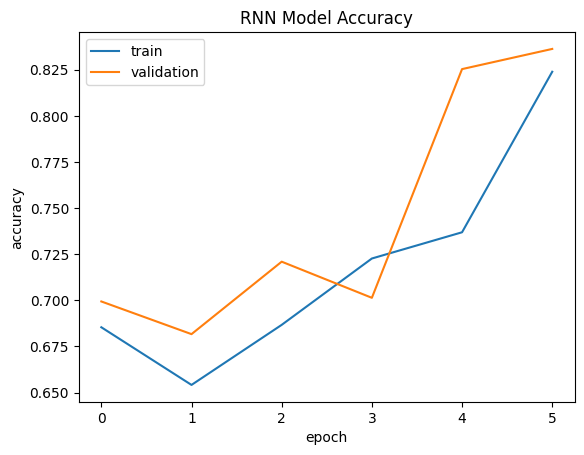

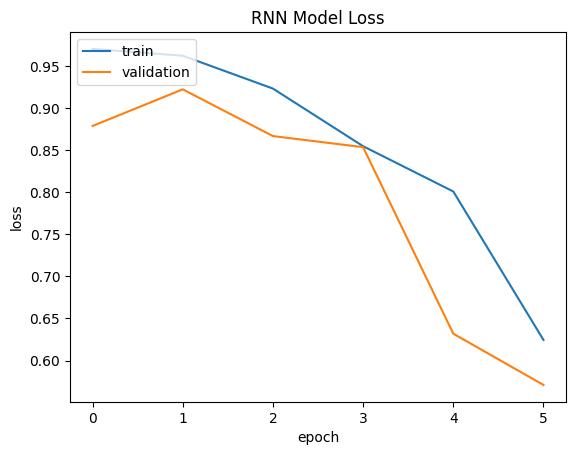

In [31]:
# RNN Model

from keras.layers import SimpleRNN

# Initialize the RNN Model
model_rnn = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model_rnn.add(embedding_layer)

# Add SimpleRNN layer
model_rnn.add(SimpleRNN(units=128, activation='relu', return_sequences=False))

# Add Dense layer for sentiment classification
model_rnn.add(Dense(5, activation='softmax'))  # 5 output units for 5 classes

# Compile the model
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_rnn = model_rnn.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

# Evaluate the model
score_rnn = model_rnn.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_rnn[0])
print("Test Accuracy:", score_rnn[1])

# Plotting accuracy and loss
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


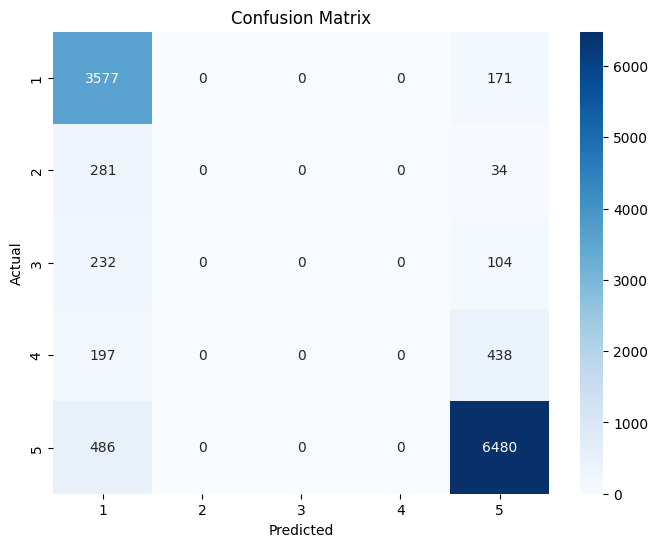

Classification Report:
              precision    recall  f1-score   support

    Rating 1       0.75      0.95      0.84      3748
    Rating 2       0.00      0.00      0.00       315
    Rating 3       0.00      0.00      0.00       336
    Rating 4       0.00      0.00      0.00       635
    Rating 5       0.90      0.93      0.91      6966

    accuracy                           0.84     12000
   macro avg       0.33      0.38      0.35     12000
weighted avg       0.75      0.84      0.79     12000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred = model_rnn.predict(X_test, verbose=1)

# Convert predictions and true labels from one-hot encoding to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[f'Rating {i}' for i in range(1, 6)]))


# Own Data Prediction

In [33]:
custom_reviews = [
    "I had a very disappointing experience with XYZ Company. The customer service was unresponsive and unhelpful when I had an issue with my order. I had to follow up multiple times before getting any resolution, and even then, it took weeks to receive a response. The product I received was not as described, and I felt like my concerns were brushed aside. Overall, I would not recommend this company to anyone, as their lack of communication and poor customer service made the entire experience frustrating.",
    "The product arrived damaged, and the replacement process was tedious and slow. Not worth the hassle.",
    "The product is okay for the price, but the quality could be improved. It’s functional but not exceptional.",
    "Decent experience, but there were a few hiccups with the setup. Works fine now but required effort to fix.",
    "I recently joined XYZ Company, and the experience has been fantastic! The work culture is incredibly supportive, and I feel like my contributions are truly valued. The management is open to feedback, and there are plenty of opportunities for growth and development. I also love the work-life balance they promote, which makes a huge difference. I would highly recommend XYZ to anyone looking for a dynamic and rewarding work environment."
]

def preprocess_custom_reviews(reviews):
    processed_reviews = []
    for review in reviews:
        # Removing HTML tags
        review = re.sub(r'<[^>]+>', '', review)
        # Removing punctuations and numbers
        review = re.sub('[^a-zA-Z]', ' ', review)
        # Removing single characters
        review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
        # Removing multiple spaces
        review = re.sub(r'\s+', ' ', review)
        processed_reviews.append(review)
    return processed_reviews

processed_custom_reviews = preprocess_custom_reviews(custom_reviews)

# Convert the processed custom reviews into sequences and pad them
custom_sequences = tokenizer.texts_to_sequences(processed_custom_reviews)
custom_padded = pad_sequences(custom_sequences, padding='post', maxlen=maxlen)

# Predict the sentiment of the custom reviews
predictions = model_rnn.predict(custom_padded)

# Interpret the output
sentiment_classes = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

for i, review in enumerate(custom_reviews):
    predicted_class = np.argmax(predictions[i])  # Get the class with the highest probability
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment_classes[predicted_class]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Review: I had a very disappointing experience with XYZ Company. The customer service was unresponsive and unhelpful when I had an issue with my order. I had to follow up multiple times before getting any resolution, and even then, it took weeks to receive a response. The product I received was not as described, and I felt like my concerns were brushed aside. Overall, I would not recommend this company to anyone, as their lack of communication and poor customer service made the entire experience frustrating.
Predicted Sentiment: Very Negative

Review: The product arrived damaged, and the replacement process was tedious and slow. Not worth the hassle.
Predicted Sentiment: Very Positive

Review: The product is okay for the price, but the quality could be improved. It’s functional but not exceptional.
Predicted Sentiment: Very Positive

Review: Decent experience, but there were a few hiccups with the setup. Works fine now but required effort to fix.
P

# Test Accuracies

In [34]:
# Evaluation Simple Neural Network model
score = model.evaluate(X_test, y_test, verbose=1)
#print("NN Test Score:", score[0])
print("NN Test Accuracy:", score[1])

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8621 - loss: 0.4466
NN Test Accuracy: 0.8640833497047424


In [35]:
# Evaluate the LSTM model
score_lstm = model_lstm.evaluate(X_test, y_test, verbose=1)
#print("LSTM Test Score:", score_lstm[0])
print("LSTM Test Accuracy:", score_lstm[1])

375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8642 - loss: 0.4393
LSTM Test Accuracy: 0.8669999837875366


In [36]:
# Evaluate the GRU model
score_gru = model_gru.evaluate(X_test, y_test, verbose=1)
#print("GRU Test Score:", score_gru[0])
print("GRU Test Accuracy:", score_gru[1])

375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6750 - loss: 0.9668
GRU Test Accuracy: 0.6788333058357239


In [37]:
# Evaluate the RNN model
score_rnn = model_rnn.evaluate(X_test, y_test, verbose=1)
#print("Test Score:", score_rnn[0])
print("RNN Test Accuracy:", score_rnn[1])

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8350 - loss: 0.5694
RNN Test Accuracy: 0.8380833268165588
